In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2, gc
from matplotlib import pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [2]:
img_size=(128,128)
batch_size = 128

DATA_DIR = '/home/chicm/data/planet'
RESULT_DIR = DATA_DIR+'/results'

df_train = pd.read_csv(DATA_DIR+'/train.csv')

print(df_train.values[:5])

[['train_0' 'haze primary']
 ['train_1' 'agriculture clear primary water']
 ['train_2' 'clear primary']
 ['train_3' 'clear primary']
 ['train_4' 'agriculture clear habitation primary road']]


In [3]:
labels = ['haze', 'cultivation', 'blooming', 'partly_cloudy', 'habitation', 'primary',
            'road', 'agriculture', 'selective_logging', 'artisinal_mine', 'slash_burn',
            'blow_down', 'cloudy', 'bare_ground', 'conventional_mine', 'clear', 'water']

cloudy_index = 12 


In [4]:
s = set(np.concatenate([i for i in [row.split(' ') for row in df_train['tags'].values]]))

In [5]:
def get_imgs(tag):
    img_fns = []
    for f, tags in df_train.values:
        if tag in tags.split(' '):
            img_fns.append(f)
    return img_fns

In [6]:
cloudy_fns = get_imgs('cloudy')
haze_fns = get_imgs('haze')
pcloudy_fns = get_imgs('partly_cloudy')
clear_fns = get_imgs('clear')

In [7]:
print(len(cloudy_fns))
print(len(haze_fns))
print(len(pcloudy_fns))
print(len(clear_fns))
print(len(cloudy_fns) + len(haze_fns) + len(pcloudy_fns) + len(clear_fns))


2330
2695
7251
28203
40479


In [8]:
count = 0
for f in tqdm(cloudy_fns):
    if f in haze_fns or f in pcloudy_fns or f in clear_fns:
        count += 1
print(count)

for f in tqdm(pcloudy_fns):
    if f in haze_fns or f in cloudy_fns or f in clear_fns:
        count += 1
print(count)

for f in tqdm(clear_fns):
    if f in haze_fns or f in cloudy_fns or f in pcloudy_fns:
        count += 1
print(count)

for f in tqdm(haze_fns):
    if f in pcloudy_fns or f in cloudy_fns or f in clear_fns:
        count += 1
print(count)
    

  3%|▎         | 222/7251 [00:00<00:03, 2215.32it/s]

0


  2%|▏         | 559/28203 [00:00<00:04, 5584.44it/s]

0


  7%|▋         | 176/2695 [00:00<00:01, 1755.53it/s]

0


100%|██████████| 2695/2695 [00:02<00:00, 1085.28it/s]

0


In [9]:
wt_labels = ['cloudy', 'partly_cloudy', 'haze', 'clear']
def one_hot(wt):
    if wt == 'cloudy':
        return [1., 0., 0., 0.]
    elif wt == 'partly_cloudy':
        return [0., 1., 0., 0.]
    elif wt == 'haze':
        return [0., 0., 1., 0.]
    elif wt == 'clear':
        return [0., 0., 0., 1.]
    else:
        pass

In [10]:
fns = cloudy_fns + pcloudy_fns + haze_fns + clear_fns[:10000]


In [11]:
fn_map = {k:'cloudy' for k in cloudy_fns}
map2 = {k:'partly_cloudy' for k in pcloudy_fns}
map3 = {k:'haze' for k in haze_fns}
map4 = {k:'clear' for k in clear_fns[:10000]}
fn_map.update(map2)
fn_map.update(map3)
fn_map.update(map4)
len(fn_map)

22276

## create validate and training data

In [12]:
val_perc = 0.15
train_fns = []
val_fns = []
for subl in [cloudy_fns, pcloudy_fns, haze_fns, clear_fns[:10000]]:
    split = (int)(len(subl)*val_perc)
    val_fns.extend(subl[:split])
    train_fns.extend(subl[split:])
print(len(val_fns))
print(val_fns[:2])
print(len(train_fns))
print(train_fns[:2])




3340
['train_12', 'train_14']
18936
['train_5985', 'train_6006']


In [13]:
train_fns = np.random.permutation(train_fns)
val_fns = np.random.permutation(val_fns)

x_train = []
y_train = []
for f in tqdm(train_fns):
    fn = DATA_DIR + '/train-jpg/'+f+'.jpg'
    img = cv2.imread(fn)
    x_train.append(cv2.resize(img, img_size))
    y_train.append(one_hot(fn_map[f]))
x_train = np.array(x_train, np.float32) / 255.
y_train = np.array(y_train, np.float32)
print(x_train.shape)
print(y_train.shape)


100%|██████████| 18936/18936 [00:20<00:00, 931.03it/s]


(18936, 128, 128, 3)
(18936, 4)


In [14]:
x_val = []
y_val = []
for f in tqdm(val_fns):
    fn = DATA_DIR + '/train-jpg/'+f+'.jpg'
    img = cv2.imread(fn)
    x_val.append(cv2.resize(img, img_size))
    y_val.append(one_hot(fn_map[f]))
x_val = np.array(x_val, np.float32) / 255.
y_val = np.array(y_val, np.float32)
print(x_val.shape)
print(y_val.shape)

100%|██████████| 3340/3340 [00:03<00:00, 1089.22it/s]


(3340, 128, 128, 3)
(3340, 4)


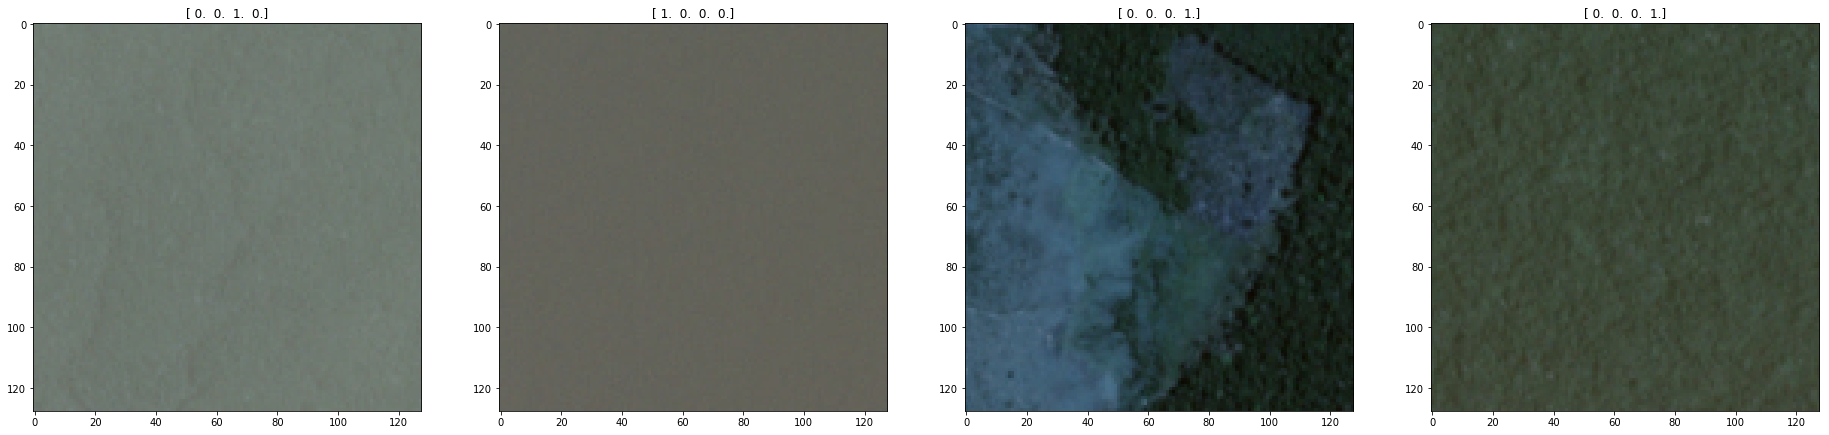

In [15]:
plt.figure(figsize=(32,32))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_train[i+20])
    plt.title(y_train[i+20])

In [16]:
from keras.utils.np_utils import to_categorical
t1 = to_categorical([0,1,2])
print(t1)

Using TensorFlow backend.


[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


In [17]:
import bcolz

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]

In [18]:
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

## train whether model

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D

def get_conv_layers(input_shape):
    return [    
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(axis=-1),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(axis=-1),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(axis=-1),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(axis=-1),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(4, activation='softmax')
        
        #Conv2D(4, (3,3), activation='relu'),
        #BatchNormalization(axis=-1),
        #GlobalAveragePooling2D(),
        #Dropout(0.4),
        #Activation('softmax')
    ]

def get_conv_model(input_shape):
    model = Sequential(get_conv_layers(input_shape))
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [29]:
model = get_conv_model(x_train.shape[1:])

In [30]:
w_file_name1 = RESULT_DIR + '/wh_1.h5'
callback1 = [EarlyStopping(monitor='val_loss', patience=10, verbose=0),
            ModelCheckpoint(w_file_name1, monitor='val_loss', save_best_only=True, verbose=0)]

In [31]:
model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs = 20, 
          validation_data=(x_val, y_val), verbose=2, callbacks=callback1)

Train on 18936 samples, validate on 3340 samples
Epoch 1/20
17s - loss: 1.0684 - acc: 0.6211 - val_loss: 2.3053 - val_acc: 0.3557
Epoch 2/20
16s - loss: 0.6822 - acc: 0.7482 - val_loss: 1.9804 - val_acc: 0.5305
Epoch 3/20
16s - loss: 0.5506 - acc: 0.8010 - val_loss: 0.8691 - val_acc: 0.7225
Epoch 4/20
16s - loss: 0.4621 - acc: 0.8297 - val_loss: 0.4168 - val_acc: 0.8479
Epoch 5/20
16s - loss: 0.4208 - acc: 0.8431 - val_loss: 0.4991 - val_acc: 0.8243
Epoch 6/20
16s - loss: 0.3901 - acc: 0.8553 - val_loss: 1.0204 - val_acc: 0.6656
Epoch 7/20
16s - loss: 0.3849 - acc: 0.8544 - val_loss: 1.9893 - val_acc: 0.5081
Epoch 8/20
16s - loss: 0.3569 - acc: 0.8682 - val_loss: 0.3916 - val_acc: 0.8512
Epoch 9/20
16s - loss: 0.3530 - acc: 0.8664 - val_loss: 0.5379 - val_acc: 0.7707
Epoch 10/20
16s - loss: 0.3407 - acc: 0.8717 - val_loss: 0.5822 - val_acc: 0.7605
Epoch 11/20
16s - loss: 0.3311 - acc: 0.8758 - val_loss: 1.4595 - val_acc: 0.6368
Epoch 12/20
16s - loss: 0.3215 - acc: 0.8780 - val_loss: 0

In [32]:
from keras import backend as K
model.load_weights(w_file_name1)
K.set_value(model.optimizer.lr, 0.0001)
w_file_name2 = RESULT_DIR + '/wh_2.h5'
callback2 = [EarlyStopping(monitor='val_loss', patience=15, verbose=0),
            ModelCheckpoint(w_file_name2, monitor='val_loss', save_best_only=True, verbose=0)]

model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs = 20, 
          validation_data=(x_val, y_val), verbose=2, callbacks = callback2)

Train on 18936 samples, validate on 3340 samples
Epoch 1/20
16s - loss: 0.3199 - acc: 0.8799 - val_loss: 0.2974 - val_acc: 0.8874
Epoch 2/20
16s - loss: 0.3064 - acc: 0.8845 - val_loss: 0.2855 - val_acc: 0.8877
Epoch 3/20
16s - loss: 0.2965 - acc: 0.8897 - val_loss: 0.3712 - val_acc: 0.8494
Epoch 4/20
16s - loss: 0.2990 - acc: 0.8892 - val_loss: 0.3660 - val_acc: 0.8509
Epoch 5/20
16s - loss: 0.2917 - acc: 0.8905 - val_loss: 0.3886 - val_acc: 0.8461
Epoch 6/20
16s - loss: 0.2910 - acc: 0.8896 - val_loss: 0.4290 - val_acc: 0.8249
Epoch 7/20
16s - loss: 0.2838 - acc: 0.8913 - val_loss: 0.2777 - val_acc: 0.8913
Epoch 8/20
16s - loss: 0.2868 - acc: 0.8904 - val_loss: 0.2766 - val_acc: 0.8934
Epoch 9/20
16s - loss: 0.2801 - acc: 0.8942 - val_loss: 0.2955 - val_acc: 0.8805
Epoch 10/20
16s - loss: 0.2780 - acc: 0.8947 - val_loss: 0.2668 - val_acc: 0.8982
Epoch 11/20
16s - loss: 0.2801 - acc: 0.8923 - val_loss: 0.2941 - val_acc: 0.8895
Epoch 12/20
16s - loss: 0.2735 - acc: 0.8963 - val_loss: 0

## Merge whether predicts with other predicts

In [35]:
PREDICTS_FILE = RESULT_DIR + '/preds'
preds = load_array(PREDICTS_FILE)
print(preds[:2])

[[ 0.01041296  0.06117052  0.01875316  0.01498115  0.0084371   0.99447513
   0.02619349  0.05540305  0.00763869  0.00288514  0.00382301  0.00421963
   0.00177683  0.00960025  0.00163995  0.95134079  0.05712077]
 [ 0.00192637  0.07143894  0.02871962  0.05925711  0.00554475  0.99649942
   0.0132723   0.03751978  0.01634973  0.0026219   0.00273673  0.01487179
   0.00153201  0.00298589  0.00154697  0.86738294  0.01148363]]


In [36]:
df_test = pd.read_csv(DATA_DIR+'/sample_submission.csv')
x_test = []
for f, tags in tqdm(df_test.values, miniters=5000):
    fn = DATA_DIR+'/test-jpg/'+f+'.jpg'
    img = cv2.imread(fn)
    x_test.append(cv2.resize(img, img_size))
x_test = np.array(x_test, np.float32) / 255.

100%|██████████| 40669/40669 [00:43<00:00, 940.21it/s]


In [38]:
model.load_weights(w_file_name2)
wh_preds = model.predict(x_test, batch_size=128)

In [40]:
save_array(RESULT_DIR+'/wh_preds', wh_preds)
print(wh_preds[:5])

[[  1.35541882e-03   1.97933623e-04   4.65415465e-03   9.93792474e-01]
 [  5.33460814e-04   1.26743282e-03   6.38092868e-04   9.97560978e-01]
 [  9.58064629e-04   9.99029279e-01   8.82666063e-06   3.81330619e-06]
 [  3.83611838e-03   9.23232958e-02   4.59800009e-03   8.99242580e-01]
 [  6.69082701e-01   3.29391271e-01   1.52004207e-03   6.09153994e-06]]


In [42]:
wh_preds = load_array(RESULT_DIR+'/wh_preds')

for i, row in enumerate(wh_preds):
    m = max(row)
    for j, e in enumerate(row):
        if abs(e-m) < 0.0001:
            wh_preds[i][j] = 1.
        else:
            wh_preds[i][j] = 0.

In [43]:
print(wh_preds[:5])

[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]]


In [46]:
labels = ['haze', 'cultivation', 'blooming', 'partly_cloudy', 'habitation', 'primary',
            'road', 'agriculture', 'selective_logging', 'artisinal_mine', 'slash_burn',
            'blow_down', 'cloudy', 'bare_ground', 'conventional_mine', 'clear', 'water']

ix=[0,3,12,15]
w_ix = [2, 1, 0, 3]

for i, row in enumerate(preds):
    for j, index in enumerate(ix):
        preds[i][index] = wh_preds[i][w_ix[j]]

In [48]:
print(preds[:5])

[[ 0.          0.06117052  0.01875316  0.          0.0084371   0.99447513
   0.02619349  0.05540305  0.00763869  0.00288514  0.00382301  0.00421963
   0.          0.00960025  0.00163995  1.          0.05712077]
 [ 0.          0.07143894  0.02871962  0.          0.00554475  0.99649942
   0.0132723   0.03751978  0.01634973  0.0026219   0.00273673  0.01487179
   0.          0.00298589  0.00154697  1.          0.01148363]
 [ 0.          0.01015364  0.00152114  1.          0.00256199  0.99617445
   0.01828577  0.02012934  0.00182815  0.00184112  0.00310062  0.00259925
   0.          0.00204873  0.00179134  0.          0.05464028]
 [ 0.          0.09884592  0.02972267  0.          0.00800206  0.9978556
   0.03859733  0.11364193  0.01726036  0.00213463  0.00413661  0.01054293
   0.          0.0047776   0.00157322  1.          0.03137597]
 [ 0.          0.0100452   0.00156985  0.          0.00631431  0.95300895
   0.01705413  0.04250793  0.00166148  0.00160695  0.00184463  0.00168691
   1.    

In [49]:
result = pd.DataFrame(preds, columns=labels)

pred_tags = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > 0.188, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    pred_tags.append(' '.join(list(a.index)))
df_test['tags'] = pred_tags
print(df_test)
df_test.to_csv(RESULT_DIR+'/sub_weather1.csv', index=False)

100%|██████████| 40669/40669 [00:57<00:00, 706.46it/s]

       image_name                                               tags
0          test_0                                      primary clear
1          test_1                                      primary clear
2          test_2                              partly_cloudy primary
3          test_3                                      primary clear
4          test_4                                     primary cloudy
5          test_5                                      primary clear
6          test_6  cultivation partly_cloudy habitation primary r...
7          test_7    habitation primary road agriculture clear water
8          test_8                                      primary clear
9          test_9                           haze primary agriculture
10        test_10            partly_cloudy primary agriculture water
11        test_11              cultivation primary agriculture clear
12        test_12                                             cloudy
13        test_13                 

## try fine tune VGG

In [19]:
from keras import applications

def get_keras_vgg_model():
    model = applications.VGG16(include_top=False, weights='imagenet')
    return model

In [20]:
vgg = get_keras_vgg_model()

train_feat = vgg.predict(x_train)
val_feat = vgg.predict(x_val)
print(train_feat.shape)
print(val_feat.shape)


(18936, 8, 8, 512)
(3340, 8, 8, 512)


In [21]:
save_array(RESULT_DIR+'/vgg_train_feats.dat', train_feat)
save_array(RESULT_DIR+'/vgg_val_feats.dat', val_feat)
save_array(RESULT_DIR+'/y_train.dat', y_train)
save_array(RESULT_DIR+'/y_val.dat', y_val)

In [22]:
train_feat = load_array(RESULT_DIR+'/vgg_train_feats.dat')
val_feat = load_array(RESULT_DIR+'/vgg_val_feats.dat')
y_train = load_array(RESULT_DIR+'/y_train.dat')
y_val = load_array(RESULT_DIR+'/y_val.dat')

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D

def get_dense_layers(input_shape):
    return [
        Flatten(input_shape=input_shape),
        Dropout(0.3),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.6),
        Dense(4, activation='softmax')
    ]

def get_dense_model(input_shape):
    model = Sequential(get_dense_layers(input_shape))
    model.compile(Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    return model

In [34]:
dense_model = get_dense_model(train_feat.shape[1:])

In [35]:
dense_model.fit(train_feat, y_train, validation_data=(val_feat, y_val), epochs = 10, verbose=2)

Train on 18936 samples, validate on 3340 samples
Epoch 1/10
9s - loss: 1.0069 - acc: 0.6246 - val_loss: 0.5752 - val_acc: 0.7596
Epoch 2/10
10s - loss: 0.6934 - acc: 0.7191 - val_loss: 0.5320 - val_acc: 0.7722
Epoch 3/10
9s - loss: 0.6381 - acc: 0.7412 - val_loss: 0.5049 - val_acc: 0.7835
Epoch 4/10
10s - loss: 0.6094 - acc: 0.7518 - val_loss: 0.5097 - val_acc: 0.7898
Epoch 5/10
9s - loss: 0.5972 - acc: 0.7576 - val_loss: 0.4866 - val_acc: 0.7991
Epoch 6/10
9s - loss: 0.5900 - acc: 0.7621 - val_loss: 0.4826 - val_acc: 0.8045
Epoch 7/10
9s - loss: 0.5681 - acc: 0.7682 - val_loss: 0.4815 - val_acc: 0.8084
Epoch 8/10
9s - loss: 0.5604 - acc: 0.7725 - val_loss: 0.4892 - val_acc: 0.7970
Epoch 9/10
9s - loss: 0.5626 - acc: 0.7745 - val_loss: 0.5321 - val_acc: 0.7760
Epoch 10/10
9s - loss: 0.5546 - acc: 0.7792 - val_loss: 0.4797 - val_acc: 0.8036


In [36]:
from keras import backend as K
K.set_value(dense_model.optimizer.lr, 0.01)
dense_model.fit(train_feat, y_train, validation_data=(val_feat, y_val), epochs = 5, verbose=2)

Train on 18936 samples, validate on 3340 samples
Epoch 1/5
9s - loss: 0.7322 - acc: 0.7063 - val_loss: 0.5405 - val_acc: 0.7790
Epoch 2/5
9s - loss: 0.6439 - acc: 0.7376 - val_loss: 0.5277 - val_acc: 0.7883
Epoch 3/5
9s - loss: 0.6241 - acc: 0.7476 - val_loss: 0.5198 - val_acc: 0.7973
Epoch 4/5
9s - loss: 0.6144 - acc: 0.7552 - val_loss: 0.5518 - val_acc: 0.7805
Epoch 5/5
9s - loss: 0.6053 - acc: 0.7595 - val_loss: 0.5084 - val_acc: 0.7931


In [ ]:

K.set_value(dense_model.optimizer.lr, 0.00001)

w_vgg_fn = RESULT_DIR + '/vgg_dense_1.h5'
dense_callbacks = [EarlyStopping(monitor='val_loss', patience=15, verbose=0),
            ModelCheckpoint(w_vgg_fn, monitor='val_loss', save_best_only=True, verbose=0)]

dense_model.fit(train_feat, y_train, validation_data=(val_feat, y_val), epochs = 50, 
                verbose=2, callbacks=dense_callbacks)


Train on 18936 samples, validate on 3340 samples
Epoch 1/50
9s - loss: 0.5790 - acc: 0.7682 - val_loss: 0.4817 - val_acc: 0.8075
Epoch 2/50
9s - loss: 0.5733 - acc: 0.7695 - val_loss: 0.4818 - val_acc: 0.8075
Epoch 3/50
10s - loss: 0.5754 - acc: 0.7729 - val_loss: 0.4806 - val_acc: 0.8084
Epoch 4/50
9s - loss: 0.5742 - acc: 0.7705 - val_loss: 0.4802 - val_acc: 0.8069
Epoch 5/50
8s - loss: 0.5744 - acc: 0.7727 - val_loss: 0.4802 - val_acc: 0.8078
Epoch 6/50
9s - loss: 0.5715 - acc: 0.7736 - val_loss: 0.4796 - val_acc: 0.8057
Epoch 7/50
9s - loss: 0.5702 - acc: 0.7745 - val_loss: 0.4777 - val_acc: 0.8108
Epoch 8/50
9s - loss: 0.5714 - acc: 0.7695 - val_loss: 0.4786 - val_acc: 0.8078
Epoch 9/50
9s - loss: 0.5698 - acc: 0.7734 - val_loss: 0.4788 - val_acc: 0.8087
Epoch 10/50
11s - loss: 0.5706 - acc: 0.7706 - val_loss: 0.4773 - val_acc: 0.8090
Epoch 11/50
9s - loss: 0.5655 - acc: 0.7729 - val_loss: 0.4771 - val_acc: 0.8093
Epoch 12/50
9s - loss: 0.5728 - acc: 0.7723 - val_loss: 0.4780 - va